In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

## LOAD DATASET

In [2]:
train = pd.read_csv("./data/train.tsv", sep = "\t", index_col = "PhraseId")
train["Phrase(original)"] = train["Phrase"]
print(train.shape)
train.head(10)

(156060, 4)


,SentenceId,Phrase,Sentiment,Phrase(original)
PhraseId,,,,
1,1,A series of escapades demonstrating the adage ...,1,A series of escapades demonstrating the adage ...
2,1,A series of escapades demonstrating the adage ...,2,A series of escapades demonstrating the adage ...
3,1,A series,2,A series
4,1,A,2,A
5,1,series,2,series
6,1,of escapades demonstrating the adage that what...,2,of escapades demonstrating the adage that what...
7,1,of,2,of
8,1,escapades demonstrating the adage that what is...,2,escapades demonstrating the adage that what is...
9,1,escapades,2,escapades


In [3]:
test = pd.read_csv("./data/test.tsv", sep = "\t", index_col = "PhraseId")
test["Phrase(original)"] = test["Phrase"]
print(test.shape)
test.head(10)

(66292, 3)


,SentenceId,Phrase,Phrase(original)
PhraseId,,,
156061,8545,An intermittently pleasing but mostly routine ...,An intermittently pleasing but mostly routine ...
156062,8545,An intermittently pleasing but mostly routine ...,An intermittently pleasing but mostly routine ...
156063,8545,An,An
156064,8545,intermittently pleasing but mostly routine effort,intermittently pleasing but mostly routine effort
156065,8545,intermittently pleasing but mostly routine,intermittently pleasing but mostly routine
156066,8545,intermittently pleasing but,intermittently pleasing but
156067,8545,intermittently pleasing,intermittently pleasing
156068,8545,intermittently,intermittently
156069,8545,pleasing,pleasing


## PREPROCESSING

## Cleantext -- 1

In [4]:
import nltk
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

In [5]:
def stem_phrase(phrase):
    words = phrase.split(" ")
    stemmed_words = []

    for word in words:
        stemmed_word = stemmer.stem(word)
        stemmed_words.append(stemmed_word)

    stemmed_phrase = " ".join(stemmed_words)

    return stemmed_phrase

# Train
tqdm.pandas(desc="Stemming... (train)")

train["Phrase"] = train["Phrase"].progress_apply(stem_phrase)

print(train.shape)
train.head()

# Test
tqdm.pandas(desc = "Stemming... (test)")

test["Phrase"] = test["Phrase"].progress_apply(stem_phrase)

print(test.shape)
test.head()


Stemming... (test):   2%|▏         | 1405/66292 [00:00<00:04, 14048.20it/s]

(156060, 4)


Stemming... (test): 100%|██████████| 66292/66292 [00:05<00:00, 12026.89it/s]

(66292, 3)


,SentenceId,Phrase,Phrase(original)
PhraseId,,,
156061,8545,an intermitt pleas but most routin effort .,An intermittently pleasing but mostly routine ...
156062,8545,an intermitt pleas but most routin effort,An intermittently pleasing but mostly routine ...
156063,8545,an,An
156064,8545,intermitt pleas but most routin effort,intermittently pleasing but mostly routine effort
156065,8545,intermitt pleas but most routin,intermittently pleasing but mostly routine


# Cleantext -- 2

In [6]:
def clean_text(phrase):
    phrase = phrase.replace("n't", "not")
    phrase = phrase.replace("not", "no")
    phrase = phrase.replace("hopeless", "bad")
    phrase = phrase.replace("good", "best")
    phrase = phrase.replace("excellent", "best")
    phrase = phrase.replace("funni", "fun")
    phrase = phrase.replace("funny", "fun")
    phrase = phrase.replace("littl", "little")
    phrase = phrase.replace("the movi", "movie")
    phrase = phrase.replace("veri", "very")
    phrase = phrase.replace("onli", "only")
    phrase = phrase.replace("comedi", "comedy")
    phrase = phrase.replace("veri", "very")
    phrase = phrase.replace("stori", "story")
    phrase = phrase.replace("charact", "character")

    return phrase

train["Phrase"] = train["Phrase"].apply(clean_text)
test["Phrase"] = test["Phrase"].apply(clean_text)

## one Hot Encode Phrases

##### CountVectorizer

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 30000, ngram_range = (1,4), stop_words =['the',
'of',
'to',
'it',
'in',
'that',
'an',
'of the',
'this',
'his',
'about',
'at',
'or',
'than',
'from',
'in the',
'are',
'so',
'rrb',
'the film',
'who',
'lrb',
'to the',
'doe',
'do',
'for the',
'director',
'been',
'ani',
'on the'])

vectorizer.fit(train["Phrase"])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=30000, min_df=1,
        ngram_range=(1, 4), preprocessor=None,
        stop_words=['the', 'of', 'to', 'it', 'in', 'that', 'an', 'of the', 'this', 'his', 'about', 'at', 'or', 'than', 'from', 'in the', 'are', 'so', 'rrb', 'the film', 'who', 'lrb', 'to the', 'doe', 'do', 'for the', 'director', 'been', 'ani', 'on the'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [8]:
X_train = vectorizer.transform(train["Phrase"])
# applies the params from fiting to data

print(X_train.shape)
X_train

(156060, 30000)


<156060x30000 sparse matrix of type '<class 'numpy.int64'>'
	with 1197794 stored elements in Compressed Sparse Row format>

In [9]:
columns = vectorizer.get_feature_names()# <- vocab
# "not funny" in columns

train_vector = pd.DataFrame(X_train.toarray(), columns= columns)
print(train_vector.shape)

(156060, 30000)


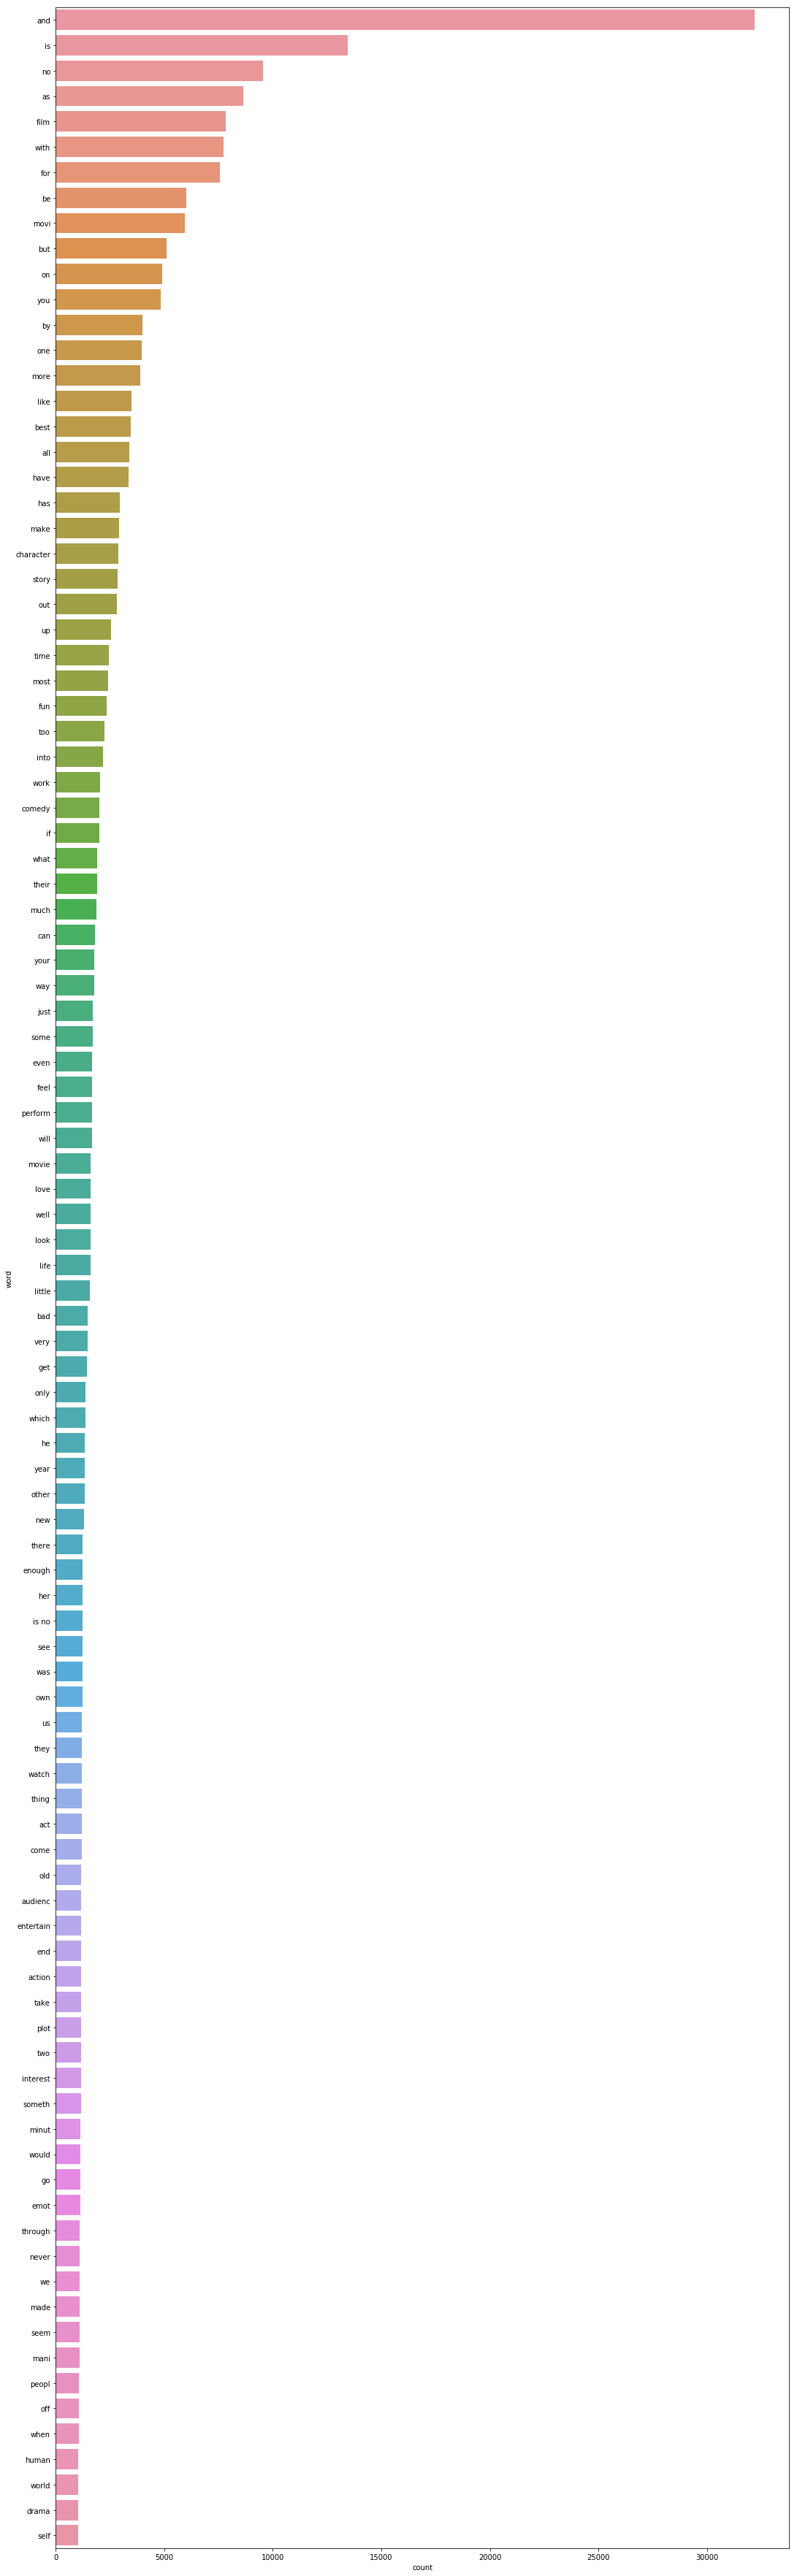

In [10]:
# Visualize

import matplotlib.pyplot as plt

dictionary = {}

# This takes a while
# This will take each train dataset's word and count the frequency in dictionary form.
for column in train_vector.columns:
    dictionary[column] = train_vector[column].sum()

dictionary_dataframe = pd.DataFrame.from_dict({'word': list(dictionary.keys()), 'count': list(dictionary.values())})
dictionary_dataframe = dictionary_dataframe.sort_values('count', ascending=False)
dictionary_dataframe = dictionary_dataframe[0:100]

%matplotlib inline
import seaborn as sns

figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 64)

sns.barplot(data=dictionary_dataframe, y="word", x="count", ax=ax)
# dictionary_dataframe.to_csv("frequency.csv")

##### TfidfVectorizer

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

char_vectorizer = TfidfVectorizer(analyzer = 'char', 
                                  max_features = 10000, 
                                  ngram_range = (1,9))

char_vectorizer.fit(train["Phrase"])
%time

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


In [12]:
word_vectorizer = TfidfVectorizer(analyzer = 'word', 
                                  max_features = 30000, 
                                  ngram_range = (1,4))

word_vectorizer.fit(train["Phrase"])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=30000, min_df=1,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

### Fit and Transform 

In [13]:
X_train_word = word_vectorizer.transform(train["Phrase"])
print(X_train_word.shape)
X_train_char = char_vectorizer.transform(train["Phrase"])
print(X_train_char.shape)

from scipy.sparse import hstack #vstack, hstack (word, character to merge )
X_train = hstack([X_train_char, X_train_word])
print(X_train.shape)
X_train

(156060, 30000)
(156060, 10000)
(156060, 40000)


<156060x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 19680572 stored elements in COOrdinate format>

In [14]:
X_test_word = word_vectorizer.transform(test["Phrase"])
print(X_test_word.shape)
X_test_char = char_vectorizer.transform(test["Phrase"])
print(X_test_char.shape)

X_test = hstack([X_test_char, X_test_word])
print(X_test.shape)
X_test

(66292, 30000)
(66292, 10000)
(66292, 40000)


<66292x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 7612200 stored elements in COOrdinate format>

In [15]:
y_train = train["Sentiment"]

print(y_train.shape)
y_train.head()

(156060,)


PhraseId
1    1
2    2
3    2
4    2
5    2
Name: Sentiment, dtype: int64

## Score 

In [16]:
from sklearn.linear_model import SGDClassifier

seed = 23

model = SGDClassifier(n_jobs=-1,
                      alpha = 0.00005,
                      random_state=seed)

model

SGDClassifier(alpha=5e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=23, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [17]:
#cross validation

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

predictions = cross_val_predict(model, X_train, y_train, cv = 5)

score = accuracy_score(y_train, predictions)

print("Score = {0:5f}".format(score))


/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/rosek

Score = 0.592452


In [18]:
from sklearn.model_selection import cross_val_score, GroupKFold
# from sklearn.cross_validation import cross_val_score, GroupKFold

kfold = GroupKFold(n_splits=5)

score = cross_val_score(model, X_train, y_train, cv=kfold, groups=train["SentenceId"]).mean()

print("Score = {0:.5f}".format(score))

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/rosek

Score = 0.59852


In [19]:
import xgboost as xgb

In [20]:
dtrain = xgb.DMatrix(X_train, label = y_train)

In [21]:
params = {
    'booster': 'gblinear',
    'objective': 'multi:softmax',
    'lambda': 2.186753e-03,
    'alpha': 1.286904,
    'lambda_bias': 6.191707e+00,
    'num_class': 5,
    'nthread':2,
}

booster = xgb.train(params, dtrain, num_boost_round=98)
booster

In [22]:
dtest = xgb.DMatrix(X_test.toarray())

## Predictions

In [29]:
predictions = booster.predict(dtest)
print(predictions.shape)
predictions[0:10]

(66292,)


array([ 3.,  3.,  2.,  3.,  3.,  3.,  3.,  2.,  3.,  2.], dtype=float32)

# Submit

In [30]:
submission = pd.read_csv("./data/sampleSubmission.csv", index_col="PhraseId")

submission["Sentiment"] = predictions

print(submission.shape)
submission.head()

(66292, 1)


,Sentiment
PhraseId,
156061,3.0
156062,3.0
156063,2.0
156064,3.0
156065,3.0


In [31]:
submission.to_csv("tfidf-xgboost.csv")